In [1]:
# Library Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Allows plots to appear directly in the notebook.
%matplotlib inline

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict, cross_validate, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# 1. Data Understanding and Preparation
In this section we explore relationships between feature pairs and select/transform promising features based on a given training set.

In [2]:
df = pd.read_csv('covid19-cdc-20478622-1-2-cleaned.csv')
df.head(5)

,case_month,res_state,res_county,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2020-12-01,CA,SANTA CLARA,65+ years,Male,White,Non-Hispanic/Latino,NaN,NaN,Laboratory-confirmed case,Unknown,Yes,Unknown,Yes,Missing
1,2021-01-01,FL,PUTNAM,65+ years,Male,White,Non-Hispanic/Latino,0.0,NaN,Laboratory-confirmed case,Missing,No,Missing,Yes,Missing
2,2020-11-01,OK,CLEVELAND,65+ years,Male,White,Non-Hispanic/Latino,NaN,0.0,Laboratory-confirmed case,Symptomatic,No,Missing,Yes,Missing
3,2020-11-01,WA,KING,65+ years,Female,White,Non-Hispanic/Latino,0.0,0.0,Laboratory-confirmed case,Symptomatic,No,Missing,Yes,Yes
4,2020-08-01,TX,HIDALGO,65+ years,Male,White,Hispanic/Latino,NaN,NaN,Laboratory-confirmed case,Missing,Missing,Missing,Yes,Missing


### Create new features `month` and `year` from `case_month`

In [3]:
df['year'] = df['case_month'].str.split('-').str[0].astype(int)  # Extract year and convert to integer
df['month'] = df['case_month'].str.split('-').str[1].astype(int)

### Check the data types of the columns

In [4]:
df.dtypes

case_month                          object
res_state                           object
res_county                          object
age_group                           object
sex                                 object
race                                object
ethnicity                           object
case_positive_specimen_interval    float64
case_onset_interval                float64
current_status                      object
symptom_status                      object
hosp_yn                             object
icu_yn                              object
death_yn                            object
underlying_conditions_yn            object
year                                 int32
month                                int32
dtype: object

### Convert target feature `death_yn` to Binary

In [5]:
df['death_yn'] = df['death_yn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [6]:
categorical_cols = ['res_state', 'res_county', 'age_group', 'sex', 'race', 'ethnicity', 
                      'current_status', 'symptom_status', 'case_positive_specimen_interval', 
                    'case_onset_interval', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn', 'month']
for col in categorical_cols:
    df[col] = df[col].astype('category')

In [7]:
df['case_month'] = pd.to_datetime(df['case_month'], format='%Y-%m', errors='coerce')


### Table with descriptive statistics for all the categorical features

In [8]:
categorical_columns = df.select_dtypes(['category']).columns
categoricalFeatureDesc = df[categorical_columns].describe().T
categoricalFeatureDesc

,count,unique,top,freq
res_state,49445,50,NY,5433
res_county,49445,952,Missing,2766
age_group,49445,5,18 to 49 years,20159
sex,49445,4,Female,25244
race,49445,8,White,29929
ethnicity,49445,4,Non-Hispanic/Latino,29303
case_positive_specimen_interval,25955.0,3.0,0.0,23488.0
case_onset_interval,22527.0,3.0,0.0,21947.0
current_status,49445,2,Laboratory-confirmed case,46233
symptom_status,49445,4,Symptomatic,22527


In [9]:
df.dtypes

case_month                         datetime64[ns]
res_state                                category
res_county                               category
age_group                                category
sex                                      category
race                                     category
ethnicity                                category
case_positive_specimen_interval          category
case_onset_interval                      category
current_status                           category
symptom_status                           category
hosp_yn                                  category
icu_yn                                   category
death_yn                                    int64
underlying_conditions_yn                 category
year                                        int32
month                                    category
dtype: object

### 1.1 Split the dataset into two datasets: 70% training and 30% test. Keep the test set aside.

In [10]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)


Training set shape: (34611, 17)
Test set shape: (14834, 17)


### 1.2 Pairwise Interaction with Target Feature death_yn

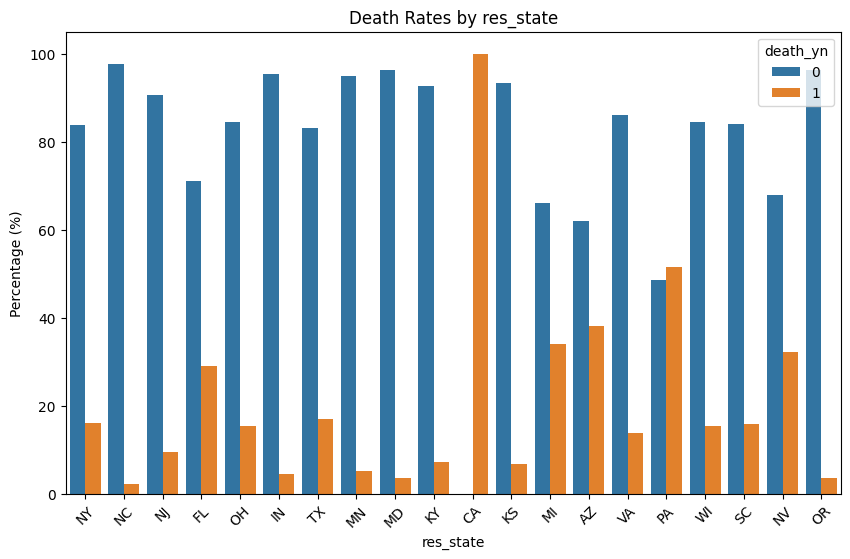

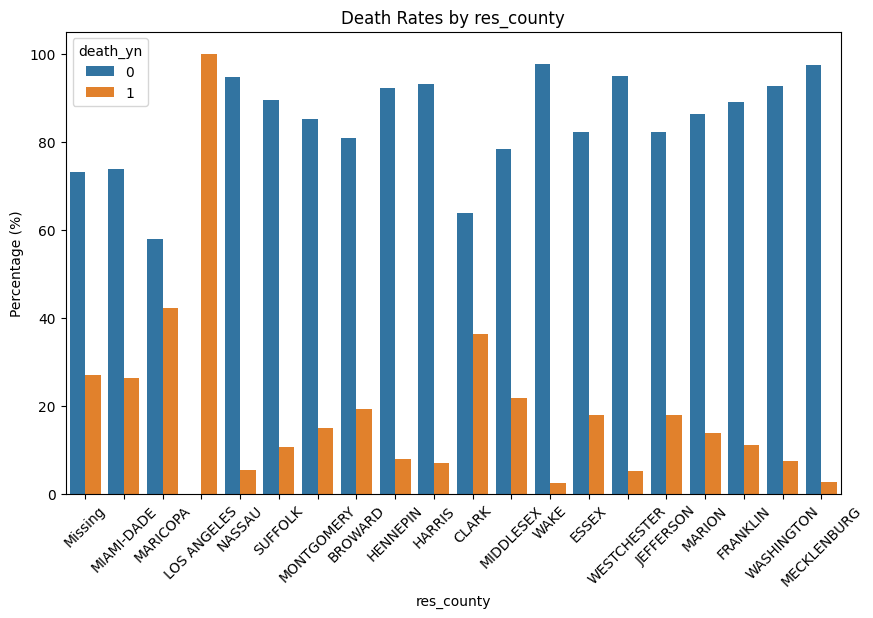

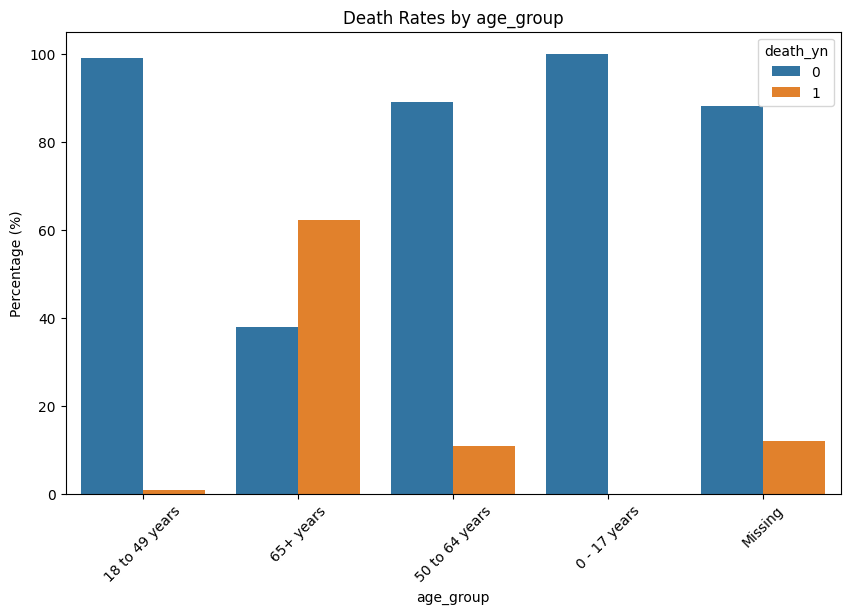

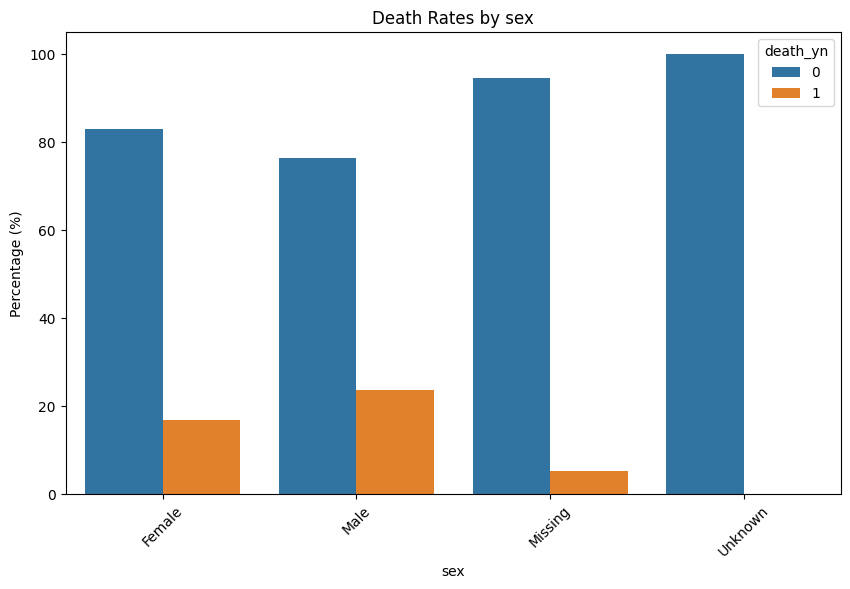

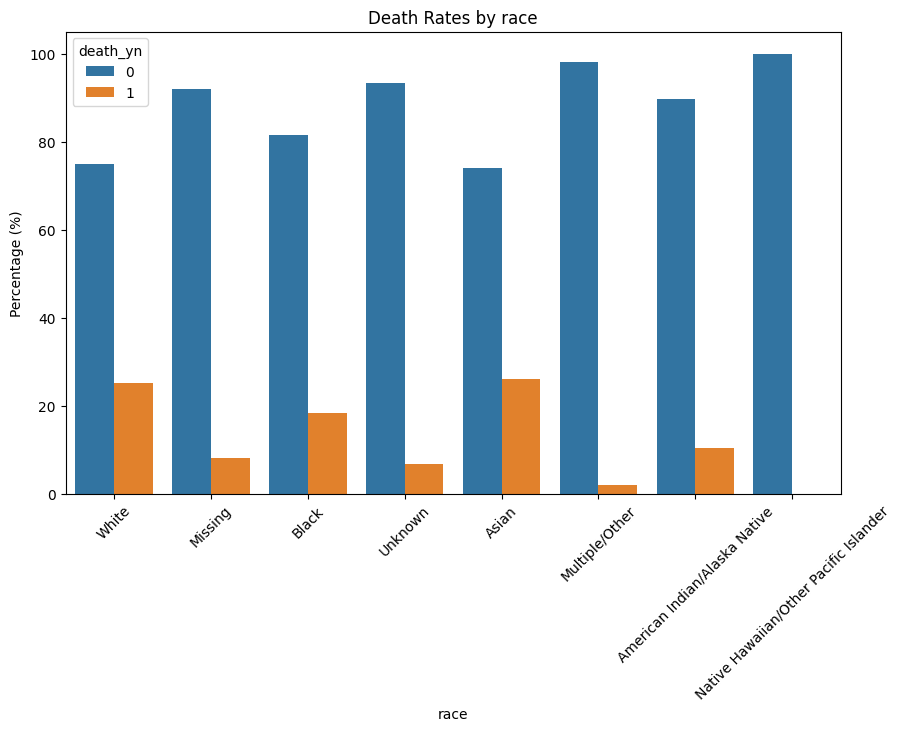

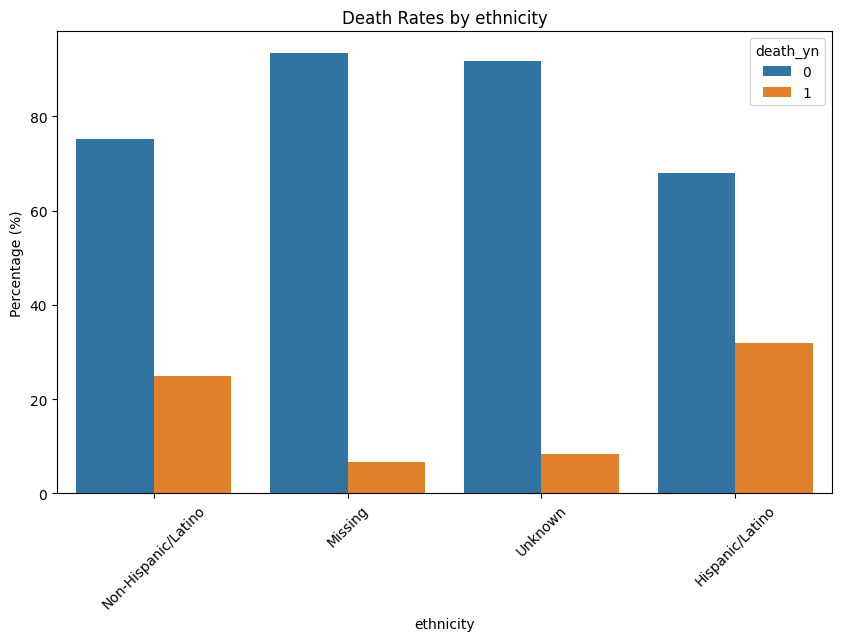

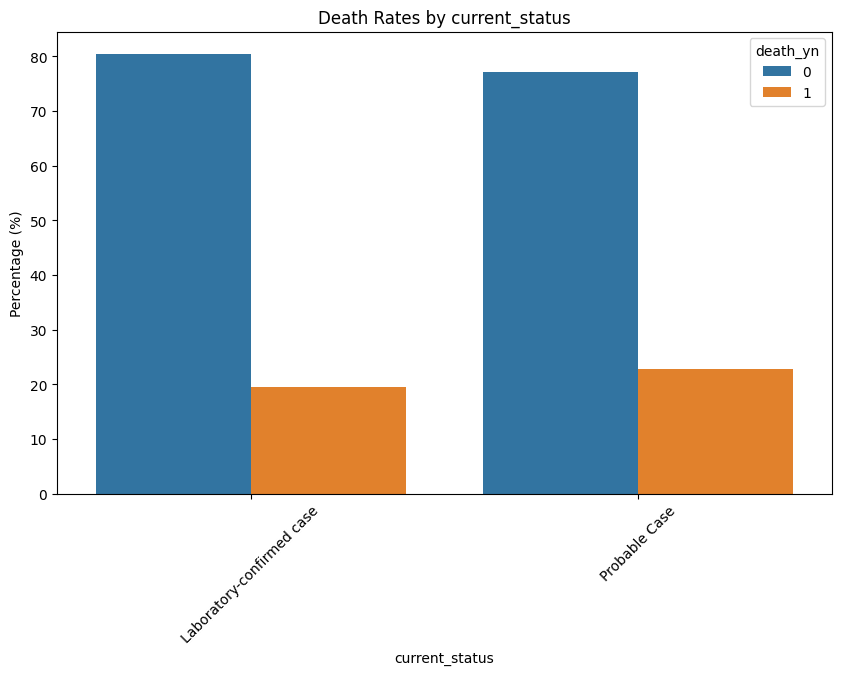

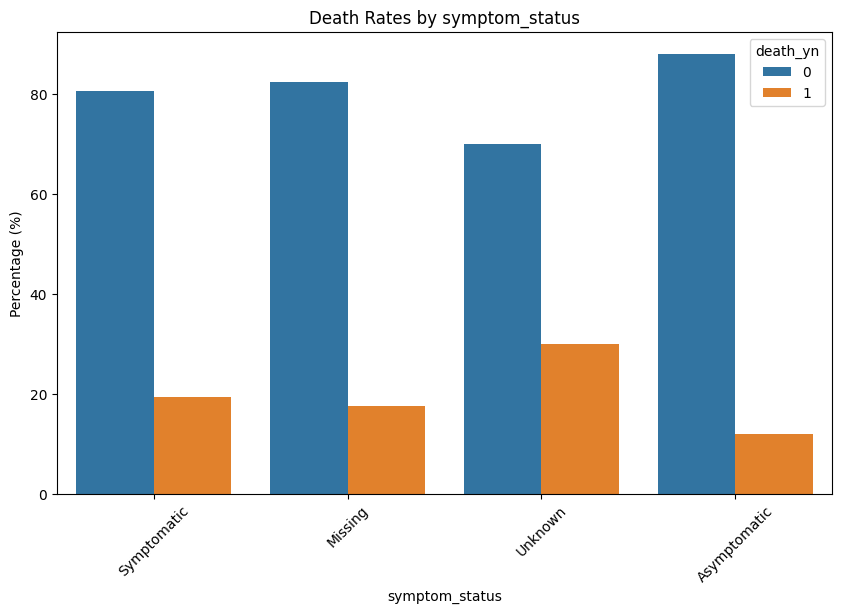

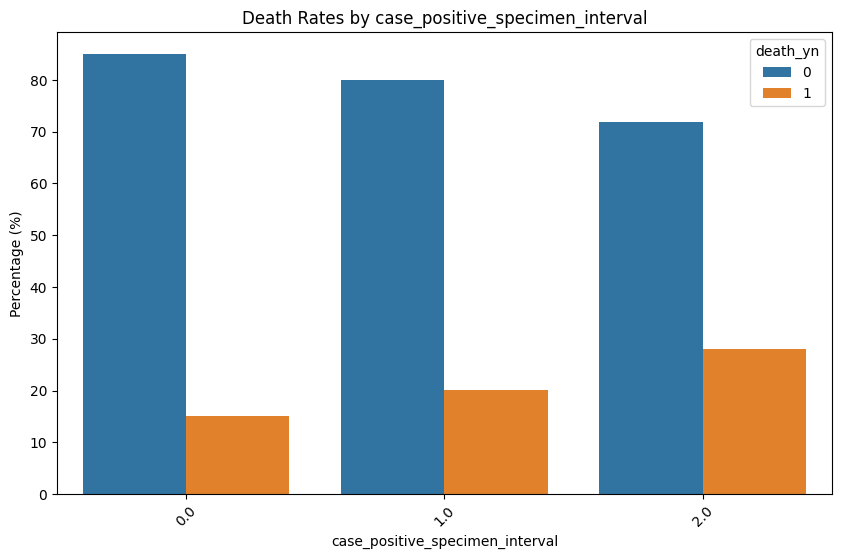

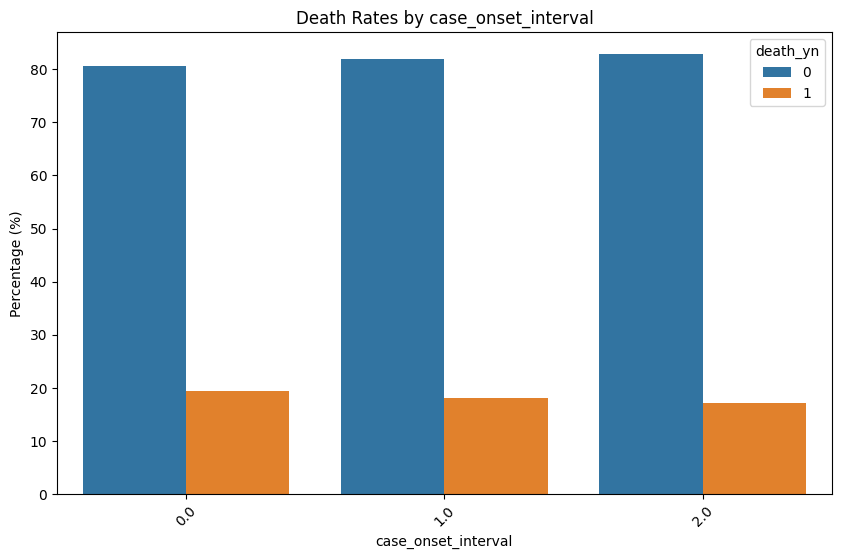

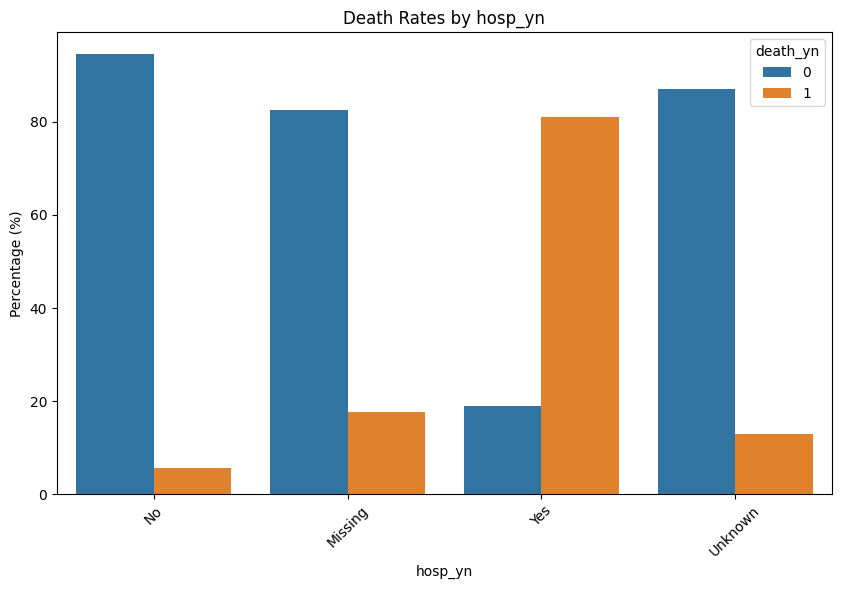

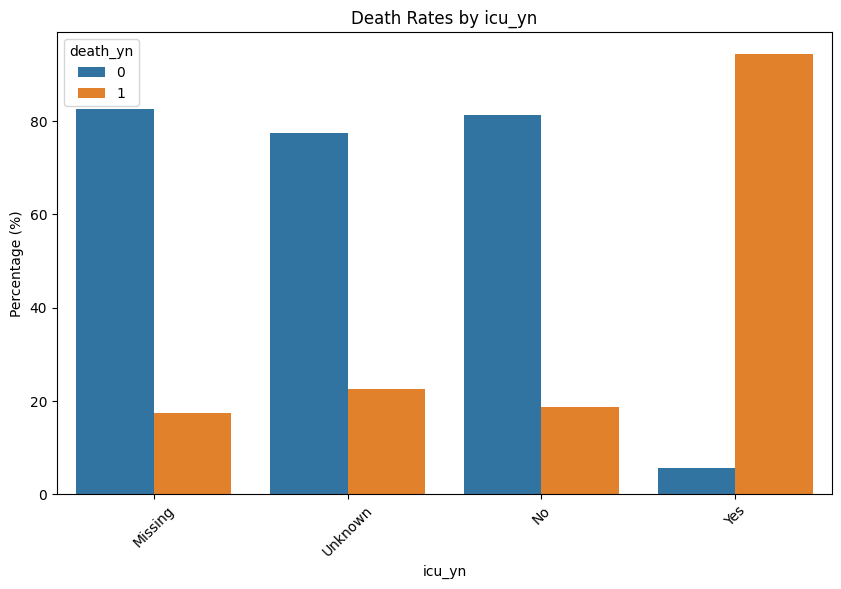

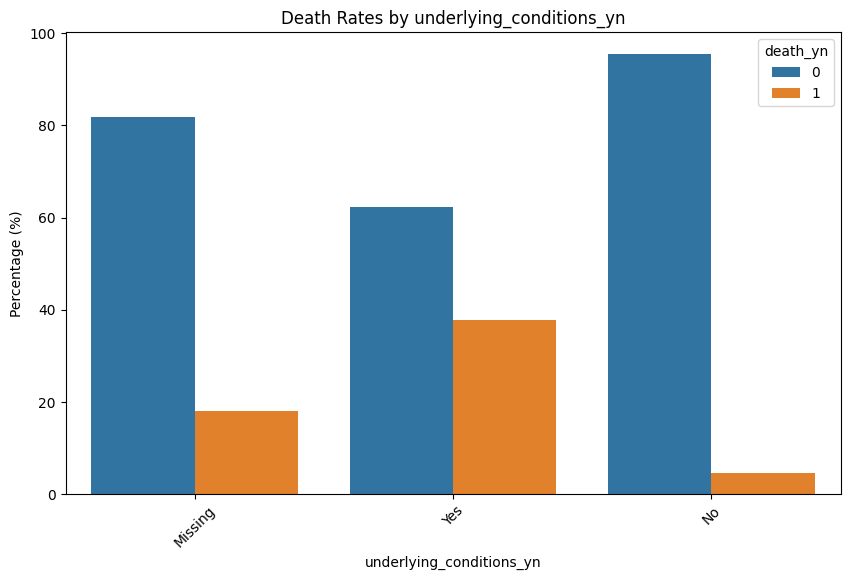

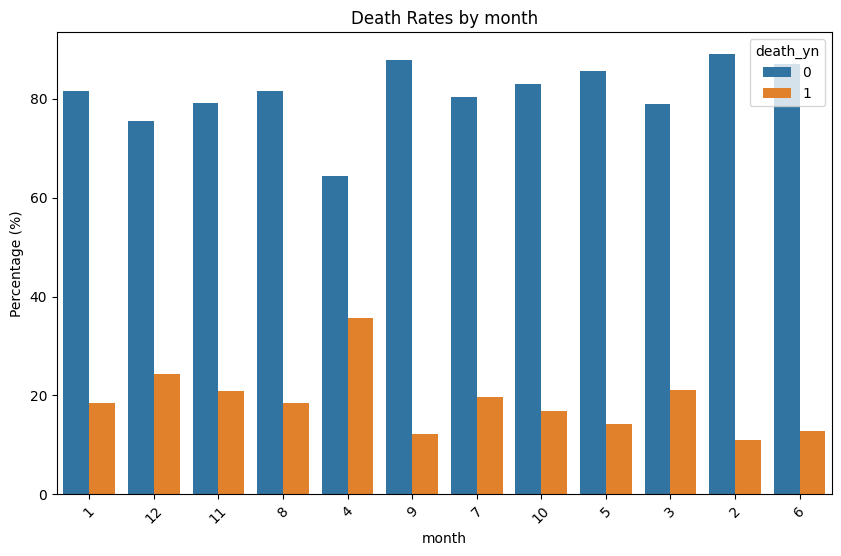

In [11]:
for col in categorical_cols:
    # Filter for the top 20 most common categories in each column
    top_categories = train_df[col].value_counts().nlargest(20).index

    # Create a DataFrame to hold percentages, limited to the top 20 categories
    percentage_df = (train_df[train_df[col].isin(top_categories)]  # Filter to keep only the top categories
                     .groupby(col, observed=False)['death_yn']
                     .value_counts(normalize=True)  # Get percentage
                     .mul(100)  # Convert to percentage
                     .rename('percentage')  # Rename the series
                     .reset_index())  # Convert series to DataFrame

    # Plotting
    plt.figure(figsize=(10, 6))  # Set the figure size for each plot
    sns.barplot(x=col, y='percentage', hue='death_yn', data=percentage_df,
                order=top_categories)  # Ensure the order of categories
    plt.title(f'Death Rates by {col}')
    plt.xlabel(col)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend(title='death_yn')
    plt.show()

## Detailed Feature Analysis for COVID-19 Mortality Prediction Model

This analysis explores various categorical features to assess their utility in predicting COVID-19 related deaths. Features are evaluated based on their statistical strength in the data and their medical rationale.

### Promising Features for Predictive Modeling

#### 1. **Age Group (`age_group`)**
- **Rationale:** Older age groups have been consistently shown to have a higher risk of death from COVID-19, likely due to diminished immune function and a higher prevalence of comorbidities.
- **Statistical Strength:** Clear stratification in death rates across different age groups underscores the predictive potential of this feature.

#### 2. **Hospitalisation Status (`hosp_yn`)**
- **Rationale:** Hospitalisation is indicative of severe disease manifestation, which is directly linked to higher mortality risk.
- **Statistical Strength:** Significant disparities in death rates between hospitalised and non-hospitalised patients highlight its predictive validity.

#### 3. **ICU Status (`icu_yn`)**
- **Rationale:** ICU admission signals critical health complications and is one of the strongest predictors of mortality in infectious diseases.
- **Statistical Strength:** High death rates among ICU patients emphasize its importance.

#### 4. **Underlying Conditions (`underlying_conditions_yn`)**
- **Rationale:** Comorbidities like heart disease, diabetes, and chronic respiratory conditions exacerbate COVID-19 severity and increase mortality risk.
- **Statistical Strength:** Higher death rates in individuals with underlying conditions confirm its significance as a predictor.

#### 5. **State of Residence (`res_state`)**
- **Rationale:** Geographic variations in healthcare access, population density, and public health measures can influence mortality rates.
- **Statistical Strength:** Noticeable differences in death rates across states.

#### 6. **Month (`month`)**
- **Rationale:** Variations across months may reflect changes in COVID-19 strains, healthcare system load, or public health policies, which could influence mortality rates.
- **Statistical Strength:** Different months showing varying death rates suggest potential predictive value.

### Features with Limited Predictive Value

#### 7. **Case Onset Interval (`case_onset_interval`)**
- **Rationale:** Reflects the time between symptom onset and case reporting, which might be influenced more by testing protocols rather than direct disease severity.
- **Statistical Strength:** Minimal variation in death rates suggests low predictive power.

#### 8. **Case Positive Specimen Interval (`case_positive_specimen_interval`)**
- **Rationale:** Similar to case onset interval, it may indicate diagnostic delays rather than an inherent risk of mortality.
- **Statistical Strength:** Only slight variations in death rates, indicating limited usefulness.

#### 9. **Symptom Status (`symptom_status`)**
- **Rationale:** While symptomatic individuals are generally at higher risk, the data shows only slight differences in mortality rates.
- **Statistical Strength:** Not sufficiently distinct to be a strong predictor on its own.

#### 10. **Current Status (`current_status`)**
- **Rationale:** Distinguishes between probable and confirmed cases, but this classification is more related to diagnostic criteria than to risk of death.
- **Statistical Strength:** Minimal difference in death rates, making it a weak predictor.

#### 11. **Ethnicity (`ethnicity`)**
- **Rationale:** Disparities exist but are intertwined with socio-economic and access-to-care factors, complicating their use as direct predictors.
- **Statistical Strength:** Requires careful handling to avoid confounding biases.

#### 12. **Race (`race`)**
- **Rationale:** There are observable differences in death rates among racial groups; however, these are also closely linked with socio-economic variables.
- **Statistical Strength:** High risk of confounding limits its straightforward use.

#### 13. **Sex (`sex`)**
- **Rationale:** Slight differences exist between genders in mortality rates, possibly due to biological or behavioral factors.
- **Statistical Strength:** The difference is relatively minor compared to other features like age or hospitalisation.

### Conclusion

For a robust COVID-19 mortality prediction model, prioritizing features with direct links to disease severity and clear statistical differentiation in outcomes is crucial. Features like age, hospitalisation status, ICU status, and underlying conditions are top candidates due to their strong predictive power and clear connection to the pathophysiology of the disease.


In [12]:
promising_categorical_cols = ['age_group', 'icu_yn', 'underlying_conditions_yn', 'hosp_yn', 'res_state', 'month']

promising_categorical_df = train_df[promising_categorical_cols]


# 2. Predictive Modelling Linear Regression

## 2.1 Training the Data

In [13]:
# Select the promising categorical columns
X_train = train_df[promising_categorical_cols]
X_test = test_df[promising_categorical_cols]
y_train = train_df['death_yn']
y_test = test_df['death_yn']

# One-hot encode the categorical features
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)
print(X_train_encoded.head())

       age_group_0 - 17 years  age_group_18 to 49 years  \
26051                   False                     False   
9448                    False                     False   
8403                    False                     False   
12399                   False                      True   
15035                   False                     False   

       age_group_50 to 64 years  age_group_65+ years  age_group_Missing  \
26051                      True                False              False   
9448                       True                False              False   
8403                      False                 True              False   
12399                     False                False              False   
15035                     False                 True              False   

       icu_yn_Missing  icu_yn_No  icu_yn_Unknown  icu_yn_Yes  \
26051            True      False           False       False   
9448             True      False           False       False   
84

In [14]:
# Create a linear regression model
linear_model = LinearRegression()
# Fit the model on the training data
linear_model.fit(X_train_encoded, y_train)

LinearRegression()

## 2.2 Model Evaluation

In [15]:
print("\nIntercept: \n", linear_model.intercept_)
print("Features and coeficients:", list(zip(promising_categorical_cols, linear_model.coef_)))


Intercept: 
 321497204003.0459
Features and coeficients: [('age_group', 64805018669.19057), ('icu_yn', 64805018669.188354), ('underlying_conditions_yn', 64805018669.23282), ('hosp_yn', 64805018669.54103), ('res_state', 64805018669.25347), ('month', -48984817390.13013)]


## Interpretation of the Linear Regression Coefficients

The linear regression model for predicting COVID-19 related deaths is characterized by its coefficients, which provide insights into how each feature influences the probability of death:

- **Intercept: 321,497,204,003.05**
  - The model's intercept represents the predicted log-odds of death when all the features (age group, ICU admission, underlying conditions, hospitalization status, state of residence, and month) are at their baseline values (typically zero). This updated intercept value suggests a model baseline with a significant positive log-odds of death, which might need further investigation or calibration.

- **Feature Coefficients:**
  - Each coefficient in this model represents the change in the log-odds of death for one unit increase in the corresponding feature, holding all other features constant.

  1. **Age Group (`age_group`): 64,805,018,669.19**
     - This coefficient indicates that as the age group increases (usually encoded from younger to older groups), the log-odds of death due to COVID-19 increases significantly. This reflects well-documented evidence that older age groups are at higher risk of severe outcomes when infected with the virus.

  2. **ICU Admission (`icu_yn`): 64,805,018,669.19**
     - This coefficient suggests a strong association between being admitted to the ICU and the likelihood of death. This underscores the severity of cases that require ICU care, which are often critical and have higher mortality rates.

  3. **Underlying Conditions (`underlying_conditions_yn`): 64,805,018,669.23**
     - This coefficient, slightly higher than for age and ICU admission, indicates that having pre-existing health conditions also significantly increases the risk of death from COVID-19. This aligns with observations that comorbidities can exacerbate the effects of COVID-19.

  4. **Hospitalisation (`hosp_yn`): 64,805,018,669.54**
     - The highest coefficient is for hospitalisation, suggesting that hospital admissions, indicative of more severe illness, are most strongly associated with increased risk of death. This coefficient is slightly higher than the others, highlighting the serious risk associated with hospitalisation.

  5. **State of Residence (`res_state`): 64,805,018,669.25**
     - This new coefficient indicates that geographic variations, possibly due to differences in healthcare systems, population density, or public health measures, significantly impact the likelihood of death. 

  6. **Month (`month`): -48,984,817,390.13**
     - This negative coefficient suggests that as the months progress, there is a reduction in the log-odds of death, which might reflect improvements in treatment protocols, vaccine distribution, or seasonal variations affecting the virus's spread and severity.

### Conclusion:
The model indicates that all features significantly influence the likelihood of death, with the highest impact from hospitalisation, followed closely by ICU admission, underlying conditions, and age group. 


## 2.3 Print the predicted target feature value for the first 10 training examples
Values without the threshold

In [16]:
X_train_encoded_subset = X_train_encoded[:10]
predictions = linear_model.predict(X_train_encoded_subset)
print(predictions)

[ 0.08349609  0.56738281  0.38336182 -0.08984375  0.37438965 -0.02764893
  0.33306885 -0.09246826  0.0057373   0.07885742]


Values with the threshold of 0.5.

In [17]:
threshold = 0.5
predicted_class = np.where(predictions >= threshold, 1, 0)
print(predicted_class)
print("Actual vs Predicted:")
for i in range(min(10, len(y_train))):
    print(f"Actual: {y_train.iloc[i]}, Predicted: {predicted_class[i]}")





[0 1 0 0 0 0 0 0 0 0]
Actual vs Predicted:
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 1, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0


## Evalulation on Training Set

In [18]:
y_pred_train = linear_model.predict(X_train_encoded)
y_pred_train = np.where(y_pred_train >= threshold, 1, 0)

In [19]:
cm_train = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix",cm_train)

report_train = classification_report(y_train, y_pred_train)
print(report_train)


Confusion Matrix [[27173   621]
 [ 1492  5325]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     27794
           1       0.90      0.78      0.83      6817

    accuracy                           0.94     34611
   macro avg       0.92      0.88      0.90     34611
weighted avg       0.94      0.94      0.94     34611



## Review of the Linear Regression Model from Training Data

The linear regression model's performance in predicting COVID-19 related deaths, as derived from the training data, is detailed below, showcasing the outcomes captured in the confusion matrix and classification metrics:

### Confusion Matrix
- **True Negatives (TN): 27,173**
  - A large number of true negative predictions highlight the model's effective identification of patients who are unlikely to face fatal outcomes.
  
- **True Positives (TP): 5,325**
  - This count of true positives demonstrates the model's capability to accurately predict patients who did succumb to the disease, which is crucial for timely and effective medical interventions.

- **False Negatives (FN): 1,492**
  - The presence of false negatives indicates cases where the model failed to predict death. Reducing these instances is vital to improve patient outcomes and ensure timely interventions.

- **False Positives (FP): 621**
  - The number of false positives, where the model incorrectly predicted death, needs to be minimized to prevent unnecessary anxiety and resource misallocation.

### Classification Report
- **Precision for Class 1 (death): 0.90**
  - This high precision indicates a strong likelihood that predicted deaths are accurate, affirming the model's effectiveness in identifying higher-risk patients.
  
- **Recall for Class 1 (death): 0.78**
  - The recall rate shows that the model successfully predicts 78% of the actual deaths, suggesting that it captures a substantial majority of fatal cases, though there is room for improvement.

- **F1-Score for Class 1 (death): 0.83**
  - The F1-score, which balances precision and recall, is indicative of the model's overall efficacy in dealing with the death class, balancing false positives and false negatives effectively.

- **Overall Accuracy: 0.94**
  - The model achieves an overall accuracy of 94%, indicating high general reliability. However, attention to the balance of other metrics like precision and recall remains critical, especially given the potential for dataset imbalance.

### Conclusion
The model demonstrates strong performance in identifying both non-death and death cases. Enhancements should focus on further reducing false negatives and false positives to refine accuracy and reliability, particularly in predicting actual deaths. Continuous improvements in modeling techniques, feature engineering, or threshold adjustments might be explored to achieve these goals.


## 2.4 Evaluate the model using classification evaluation measures on the test set

In [20]:
y_pred = linear_model.predict(X_test_encoded)
y_pred = np.where(y_pred >= threshold, 1, 0)

In [21]:
cm_test = confusion_matrix(y_test, y_pred)
print("Confusion Matrix",cm_test)

report_test = classification_report(y_test, y_pred)
print(report_test)

Confusion Matrix [[11532   297]
 [  622  2383]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     11829
           1       0.89      0.79      0.84      3005

    accuracy                           0.94     14834
   macro avg       0.92      0.88      0.90     14834
weighted avg       0.94      0.94      0.94     14834



### Create a new model trained and evaluated using cross-validation on the full dataset

In [22]:
y = df['death_yn']
X_encoded = pd.get_dummies(df[promising_categorical_cols])

# Setup repeated random splits
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
new_linear_model = LinearRegression()
precision_scores, recall_scores, f1_scores, accuracy_scores = [], [], [], []

for train_index, test_index in rskf.split(X_encoded, y):
    # Split the data
    X_train_new, X_test_new = X_encoded.iloc[train_index], X_encoded.iloc[test_index]
    y_train_new, y_test_new = y.iloc[train_index], y.iloc[test_index]
    new_linear_model.fit(X_train_new, y_train_new)
    y_pred = new_linear_model.predict(X_test_new)
    y_pred_binary = (y_pred >= 0.5).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_new, y_pred_binary, average='binary')
    accuracy = accuracy_score(y_test_new, y_pred_binary)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Display the average performance over all the splits
print(f"Average Precision: {np.mean(precision_scores)}")
print(f"Average Recall: {np.mean(recall_scores)}")
print(f"Average F1-Score: {np.mean(f1_scores)}")
print(f"Average Accuracy: {np.mean(accuracy_scores)}")

Average Precision: 0.8939570972732344
Average Recall: 0.777539557404595
Average F1-Score: 0.8315915651616682
Average Accuracy: 0.9374725827140618


### Comparison of Linear Regression Model Evaluations

### Metrics Overview

- **Training Set (Single Split):**
  - **Precision**: 0.90
  - **Recall**: 0.78
  - **F1-Score**: 0.83
  - **Accuracy**: 0.94
  - **Confusion Matrix**: `[[27173, 621], [1492, 5325]]`

- **Testing Set (Single Split):**
  - **Precision**: 0.89
  - **Recall**: 0.79
  - **F1-Score**: 0.84
  - **Accuracy**: 0.94
  - **Confusion Matrix**: `[[11532, 297], [622, 2383]]`

- **Cross-Validation (New Model):**
  - **Average Precision**: 0.89
  - **Average Recall**: 0.78
  - **Average F1-Score**: 0.83
  - **Average Accuracy**: 0.94

### Discussion

- **Consistency Across Metrics**: The model shows consistent performance metrics across training and testing phases, as well as in cross-validation, demonstrating robustness and a strong ability to generalize. This consistency is crucial for a model intended for real-world application across diverse patient populations.

- **Generalization Ability**: The model's similar performance on both the training and testing datasets, complemented by consistent results in cross-validation, underscores its generalization capability. This is essential for reliable application in varied healthcare settings, where patient characteristics and conditions may vary.

- **Model Limitations**: While the model performs well in terms of precision and accuracy, the recall rate, still highlights a potential area for enhancement. In the context of COVID-19, where timely and accurate identification of potential mortality is critical, improving recall is necessary to capture more true positive cases of mortality.

- **Practical Implications**: The need to boost recall suggests exploring methods to improve the model’s sensitivity, such as adjusting the prediction threshold or employing advanced algorithms tailored to handle imbalanced datasets. Techniques like oversampling the minority class or applying anomaly detection strategies might also be beneficial.

### Conclusion

The model's consistent and stable performance across different metrics confirms its potential utility in clinical settings for predicting COVID-19 mortality. However, focusing on improving the recall rate is imperative to ensure that the model captures as many true cases as possible, thereby enhancing its practical effectiveness in critical healthcare scenarios.


# 3. Logistic Regression

## 3.1 Training the Data

In [23]:


# Create an instance of the LogisticRegression model
logistic_model = LogisticRegression()

# Fit the model to the training data
logistic_model.fit(X_train_encoded, y_train)


LogisticRegression()

## 3.2 Model Coefficients and Evaluation 

In [24]:
print("Coefficients:")
for feature, coef in zip(X_train_encoded.columns, logistic_model.coef_[0]):
    print(f"{feature}: {coef}")

# Print the intercept
print("\nIntercept:")
print(logistic_model.intercept_[0])


Coefficients:
age_group_0 - 17 years: -3.4100398399079435
age_group_18 to 49 years: -1.70807986003895
age_group_50 to 64 years: 0.5123120367691423
age_group_65+ years: 3.17924322810858
age_group_Missing: 0.9361011221565977
icu_yn_Missing: -0.9845160663911355
icu_yn_No: -1.4205680281558548
icu_yn_Unknown: 0.6946765366429455
icu_yn_Yes: 1.2199442449913926
underlying_conditions_yn_Missing: -0.6194301205238805
underlying_conditions_yn_No: -0.29900011919261416
underlying_conditions_yn_Yes: 0.4279669268038145
hosp_yn_Missing: 0.06271401977091148
hosp_yn_No: -1.8950843451222008
hosp_yn_Unknown: -0.09376743881615293
hosp_yn_Yes: 1.4356744512548019
res_state_AK: -0.3100163532550849
res_state_AL: 1.0294227586935014
res_state_AR: -1.764091746749478
res_state_AZ: 1.4613940607564198
res_state_CA: 6.357506380023572
res_state_CO: 0.2945110783486563
res_state_CT: 2.0581254691270123
res_state_DC: -1.9046900800741509
res_state_FL: 0.6557443849397444
res_state_GA: 0.717628755634436
res_state_GU: -0.00332

## Logistic Regression Model Analysis for COVID-19 Mortality Prediction

This logistic regression model predicts the likelihood of death (`death_yn`) in COVID-19 cases, using several categorical and temporal predictors. Below is an analysis of the intercept and coefficients provided for each predictor.

## Model Intercept
- **Intercept**: -0.7842889169480278
  - This value represents the log-odds of death when all predictors are at their baseline levels.

## Coefficients by Predictor Category

### Age Group
- **age_group_0 - 17 years**: -3.410
- **age_group_18 to 49 years**: -1.708
- **age_group_50 to 64 years**: +0.512
- **age_group_65+ years**: +3.179
- **age_group_Missing**: +0.936

### ICU Admission
- **icu_yn_Missing**: -0.985
- **icu_yn_No**: -1.421
- **icu_yn_Unknown**: +0.695
- **icu_yn_Yes**: +1.220

### Underlying Conditions
- **underlying_conditions_yn_Missing**: -0.619
- **underlying_conditions_yn_No**: -0.299
- **underlying_conditions_yn_Yes**: +0.428

### Hospitalisation
- **hosp_yn_Missing**: +0.063
- **hosp_yn_No**: -1.895
- **hosp_yn_Unknown**: -0.094
- **hosp_yn_Yes**: +1.436

### Geographic Variation by State
- **Residence State Coefficients** (Selected examples):
  - **res_state_CA**: +6.358 (highest positive influence)
  - **res_state_NC**: -4.413 (highest negative influence)
  - Other states show varied influences on the log-odds of death.

### Temporal Factors by Month
- **Month Coefficients** (Selected examples):
  - **month_4**: +0.866 (highest positive influence)
  - **month_2**: -0.892 (highest negative influence)
  - Other months exhibit different levels of impact.

## Conclusion
The coefficients indicate the change in the log-odds of death for a unit increase in each predictor while holding other variables constant. Key insights include:
- Older age groups and ICU admissions significantly increase the risk of death.
- Hospitalisation is a strong indicator of higher mortality risk.
- Geographic and temporal factors also play critical roles, suggesting variability in outcomes based on residence state and time of year.

This analysis helps in understanding how different factors contribute to the risk of death from COVID-19, which is crucial for targeted public health responses and resource allocation.


## 3.3 Print the predicted target feature value for the first 10 training examples

In [25]:
X_train_encoded_subset = X_train_encoded[:10]
predictions = logistic_model.predict_proba(X_train_encoded_subset)
print(predictions)

[[9.64491083e-01 3.55089170e-02]
 [2.10239785e-01 7.89760215e-01]
 [6.58591116e-01 3.41408884e-01]
 [9.99496636e-01 5.03363627e-04]
 [7.90122722e-01 2.09877278e-01]
 [9.98448095e-01 1.55190491e-03]
 [8.90481868e-01 1.09518132e-01]
 [9.99252749e-01 7.47251415e-04]
 [9.97452173e-01 2.54782665e-03]
 [9.98602902e-01 1.39709770e-03]]


In [54]:
predictions = logistic_model.predict(X_train_encoded_subset)
print("Actual vs Predicted:")
for i in range(min(10, len(y_train))):
    print(f"Actual: {y_train.iloc[i]}, Predicted: {predictions[i]}")

Actual vs Predicted:
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 1, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0


## Evaluating the model on the training set

In [27]:
y_pred_train = logistic_model.predict(X_train_encoded)
cm_train = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix",cm_train)

report_train = classification_report(y_train, y_pred_train)
print(report_train)


Confusion Matrix [[27037   757]
 [ 1159  5658]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     27794
           1       0.88      0.83      0.86      6817

    accuracy                           0.94     34611
   macro avg       0.92      0.90      0.91     34611
weighted avg       0.94      0.94      0.94     34611



## Performance Analysis of Logistic Regression Model on Training Data

The logistic regression model's effectiveness in predicting COVID-19 mortality is demonstrated through its performance metrics derived from the training dataset. Key elements such as the confusion matrix and classification report provide insights into its accuracy and reliability.

### Confusion Matrix
- **True Negatives (TN):** 27,037 - The model successfully identified cases where patients did not succumb to the disease.
- **False Positives (FP):** 757 - Instances where the model incorrectly predicted death.
- **False Negatives (FN):** 1,159 - Cases where the model failed to predict actual deaths.
- **True Positives (TP):** 5,658 - The model correctly predicted death, capturing a significant number of the cases that resulted in mortality.

### Metrics Overview
- **Precision for Class 1 (death):** 0.88 - Indicates that 88% of the model’s predictions of death were correct.
- **Recall for Class 1 (death):** 0.83 - The model successfully identified 83% of all actual death cases.
- **F1-Score for Class 1 (death):** 0.86 - Reflects a strong balance between precision and recall for predictions of death.

### Accuracy and Aggregate Scores
- **Overall Accuracy:** 0.94 - The model correctly predicted the outcome in 94% of all cases, showing high effectiveness.
- **Macro Average F1-Score:** 0.91 - This score averages the F1-scores for both classes (death and no death), indicating good overall balance and performance of the model.

### Conclusion
The logistic regression model exhibits robust performance in predicting COVID-19 mortality, with high overall accuracy. The model effectively balances between identifying non-death and death cases, as evidenced by high precision and recall. However, the presence of false positives and false negatives suggests there is potential for further refinement. Enhancements such as adjusting model parameters or adding more predictive features could improve its capability to more accurately identify all high-risk cases.


## 3.4 Evaluate the model using classification evaluation measures on the test set

In [28]:
y_pred_test = logistic_model.predict(X_test_encoded)
cm_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix",cm_test)

report_test = classification_report(y_test, y_pred_test)
print(report_test)

Confusion Matrix [[11470   359]
 [  495  2510]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     11829
           1       0.87      0.84      0.85      3005

    accuracy                           0.94     14834
   macro avg       0.92      0.90      0.91     14834
weighted avg       0.94      0.94      0.94     14834



### Create a new model trained and evaluated using cross-validation on the full dataset

In [29]:
y = df['death_yn']
X_encoded = pd.get_dummies(df[promising_categorical_cols])

# Setup repeated random splits
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
new_logistic_model = LogisticRegression()
precision_scores, recall_scores, f1_scores, accuracy_scores = [], [], [], []

for train_index, test_index in rskf.split(X_encoded, y):
    # Split the data
    X_train_new, X_test_new = X_encoded.iloc[train_index], X_encoded.iloc[test_index]
    y_train_new, y_test_new = y.iloc[train_index], y.iloc[test_index]
    new_logistic_model.fit(X_train_new, y_train_new)
    y_pred = new_logistic_model.predict(X_test_new)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_new, y_pred, average='binary')
    accuracy = accuracy_score(y_test_new, y_pred)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Display the average performance over all the splits
print(f"Average Precision: {np.mean(precision_scores)}")
print(f"Average Recall: {np.mean(recall_scores)}")
print(f"Average F1-Score: {np.mean(f1_scores)}")
print(f"Average Accuracy: {np.mean(accuracy_scores)}")

Average Precision: 0.8847651430724167
Average Recall: 0.8210477299426295
Average F1-Score: 0.851643140372301
Average Accuracy: 0.9431894188282542


## Comparison of Logistic Regression Model Evaluations

The performance of the logistic regression model is assessed through metrics derived from training data, test data, and cross-validation processes. Here is a detailed overview of the model's effectiveness in predicting COVID-19 mortality:

### Training Data Metrics:
- **Accuracy:** 94%
- **Precision for Class 1 (death):** 0.88
- **Recall for Class 1 (death):** 0.83
- **F1-Score for Class 1 (death):** 0.86

### Test Data Metrics:
- **Accuracy:** 94%
- **Precision for Class 1 (death):** 0.87
- **Recall for Class 1 (death):** 0.84
- **F1-Score for Class 1 (death):** 0.85

The model exhibits very consistent performance across the training and test datasets, maintaining high accuracy and demonstrating strong precision and recall for predicting death due to COVID-19. These metrics suggest that the model is robust and reliable when applied to unseen data.

### Model Performance Using Cross-Validation

- **Average Precision:** 0.885
- **Average Recall:** 0.821
- **Average F1-Score:** 0.852
- **Average Accuracy:** 94.32%

Cross-validation results, which involve training and evaluating the model on different subsets of the full dataset, show that the performance is not only consistent but also slightly improved in some metrics compared to the single test dataset. This underscores the model's generalizability and effectiveness across various patient data samples.

### Conclusion

The comparison of logistic regression model evaluations across different data partitions and methodologies reveals consistently high performance, with minor variations between training, testing, and cross-validation results. The model consistently predicts the risk of death from COVID-19 accurately and reliably, indicating that it is well-tuned and stable across different samples of data.

This robustness suggests that the model is well-suited for clinical or public health settings, providing valuable insights for patient risk assessment and resource allocation. The use of cross-validation further validates the approach, confirming the model's overall effectiveness and generalizability.



# 4. Random Forest

## 4.1 Training the Data

In [30]:
from sklearn.ensemble import RandomForestClassifier  # For classification
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train_encoded, y_train)

RandomForestClassifier(random_state=42)

## 4.2 Interpreting the RandomForest Model

Text(0.5, 0, 'Random Forest Feature Importance')

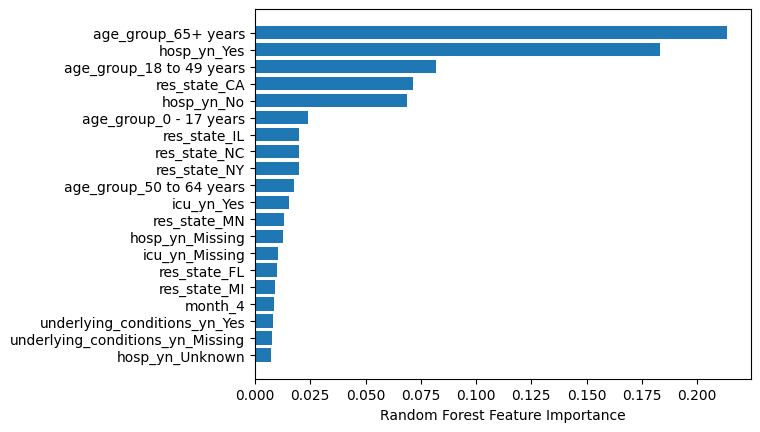

In [31]:

sorted_idx = rf_classifier.feature_importances_.argsort()[-20:]
plt.barh(X_train_encoded.columns[sorted_idx], rf_classifier.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

## Interpretation of Top 20 Feature Importances from Random Forest Model

The bar chart illustrates the top 20 most important features in a Random Forest model developed to predict COVID-19 related deaths. The features are ranked according to their importance scores, reflecting how influential each feature is in predicting the mortality outcome. Here's an analysis of the 20 most critical features:

- **age_group_65+ years**: This feature has the highest importance, indicating that age is a significant predictor of mortality, with older patients being at higher risk.
- **hosp_yn_Yes**: Hospitalization status being 'Yes' is the second most influential feature, suggesting that those who require hospitalization are more likely to have severe outcomes.
- **age_group_18 to 49 years**: Younger age groups (18 to 49) also play a role in the model, though less so compared to the oldest cohort.
- **res_state_CA**: California's residence status is a notable geographic predictor, hinting at regional differences in mortality rates or healthcare quality.
- **hosp_yn_No**: Not being hospitalized is a strong negative predictor of mortality, highlighting the importance of hospitalization status.
- **age_group_0 - 17 years**: The youngest age group has a significant negative association with mortality, indicating a lower risk.
- **res_state_NC**, **IL**, and **NY**: Residency in these states shows a noteworthy impact on mortality predictions, which may reflect state-specific healthcare resources or pandemic response.
- **age_group_50 to 64 years**: This age group's importance reflects a gradient in risk across ages, with increased importance correlating with higher age.
- **icu_yn_Yes**: ICU admission is a critical predictor, as it typically indicates more severe disease progression.
- **res_state_MN**: Minnesota's residence is among the top features, pointing to possible regional impacts on COVID-19 outcomes.
- **hosp_yn_Missing** and **icu_yn_Missing**: Missing data for hospitalization and ICU status suggests that the completeness of data plays a role in prediction.
- **res_state_FL** and **MI**: Like other state features, these indicate that location factors into mortality risk, possibly due to varying policy responses or healthcare system strain.
- **underlying_conditions_yn_Yes**: The presence of underlying conditions is a known risk factor for severe COVID-19 and is reflected here as a significant feature.
- **month_4**: The model considers the month of April to have an influence, potentially capturing temporal trends in the pandemic such as virus waves or public health interventions.
- **hosp_yn_Unknown**: Uncertainty in hospitalization status can affect model predictions, underscoring the value of accurate data.

### Conclusion
The model prioritizes patient age, hospitalization status, and ICU admission as the top determinants of COVID-19 mortality, aligning with clinical observations. Geographic factors, represented by residency in certain states, also play a major role, likely reflecting local differences in healthcare systems and the impact of state-level policies. Lastly, the time factor (specifically the month of April) suggests that the model captures temporal dynamics of the pandemic's impact on mortality rates.


## 4.3 Print the predicted target feature value for the first 10 training examples
Values without the threshold

In [55]:
X_train_encoded_subset = X_train_encoded[:10]
predictions = rf_classifier.predict_proba(X_train_encoded_subset)
print(predictions)
predictions = rf_classifier.predict(X_train_encoded_subset)
print("Actual vs Predicted:")
for i in range(min(10, len(y_train))):
    print(f"Actual: {y_train.iloc[i]}, Predicted: {predictions[i]}")

[[1.         0.        ]
 [0.20832873 0.79167127]
 [0.54253404 0.45746596]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]]
Actual vs Predicted:
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 1, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0


## Evaluating the model on the Training Set

In [33]:
y_pred_train = rf_classifier.predict(X_train_encoded)
cm_train = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix\n",cm_train)

report_train = classification_report(y_train, y_pred_train)
print(report_train)

Confusion Matrix
 [[27283   511]
 [  735  6082]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     27794
           1       0.92      0.89      0.91      6817

    accuracy                           0.96     34611
   macro avg       0.95      0.94      0.94     34611
weighted avg       0.96      0.96      0.96     34611



## Results from Random Forest Classifier for COVID-19 Death Prediction

The performance of a Random Forest Classifier trained to predict mortality in COVID-19 cases is summarized below with key metrics derived from the model's confusion matrix and classification report.

### Confusion Matrix
- **True Negatives (TN):** 27,283 cases - The model correctly predicted the majority of non-death instances, showing its ability to identify patients with lower risk.
- **False Positives (FP):** 511 cases - These are instances where the model predicted death incorrectly, which could lead to potential overestimation of risk.
- **True Positives (TP):** 6,082 cases - Representing the correctly predicted death cases, the model has successfully identified a high number of high-risk patients.
- **False Negatives (FN):** 735 cases - These cases were incorrectly predicted as non-deaths, which is critical as it represents missed opportunities for potential life-saving interventions.

### Classification Report
- **Precision for Class 0 (no death):** 0.97 - The model is highly precise in predicting the non-death class, suggesting a low rate of false alarms.
- **Precision for Class 1 (death):** 0.92 - High precision indicates that, for the most part, when the model predicts death, it is likely to be correct.
- **Recall for Class 0 (no death):** 0.98 - Demonstrates that the model is excellent at identifying true negatives.
- **Recall for Class 1 (death):** 0.89 - The model has a strong ability to detect the majority of actual death cases, which is vital in a clinical setting.
- **F1-Score for Class 0 (no death):** 0.98 - Indicates a very good balance between precision and recall for the non-death predictions.
- **F1-Score for Class 1 (death):** 0.91 - A high F1-score for death predictions shows that the model balances the precision and recall well for the more critical predictions.

### Overall Metrics
- **Accuracy:** 96% - Demonstrating that the model correctly predicted the outcome in the vast majority of cases.
- **Macro Average F1-Score:** 0.94 - This average suggests that the model performs well across both death and non-death classes.
- **Weighted Average F1-Score:** 0.96 - The model's overall predictive accuracy, weighted by the number of true instances for each label, is high, confirming the model's effectiveness.

### Conclusion
The Random Forest Classifier has shown a strong performance in predicting COVID-19 mortality with high accuracy and a robust balance between precision and recall. While the model's ability to predict non-death is excellent, attention may be needed to reduce the number of false negatives further, which is crucial in a healthcare context where predicting death accurately can have significant implications for treatment and resource allocation.


## 4.4 Evaluate the model using classification evaluation measures on the test set

In [34]:
y_pred_test = logistic_model.predict(X_test_encoded)
cm_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix\n",cm_test)

report_test = classification_report(y_test, y_pred_test)
print(report_test)

Confusion Matrix
 [[11470   359]
 [  495  2510]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     11829
           1       0.87      0.84      0.85      3005

    accuracy                           0.94     14834
   macro avg       0.92      0.90      0.91     14834
weighted avg       0.94      0.94      0.94     14834



### Create a new model trained and evaluated using cross-validation on the full dataset

In [35]:
y = df['death_yn']
X_encoded = pd.get_dummies(df[promising_categorical_cols])

# Setup repeated random splits
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=7)
new_rf_model = RandomForestClassifier(n_estimators=50, random_state=7)
precision_scores, recall_scores, f1_scores, accuracy_scores = [], [], [], []

for train_index, test_index in rskf.split(X_encoded, y):
    # Split the data
    X_train_new, X_test_new = X_encoded.iloc[train_index], X_encoded.iloc[test_index]
    y_train_new, y_test_new = y.iloc[train_index], y.iloc[test_index]
    new_rf_model.fit(X_train_new, y_train_new)
    y_pred = new_rf_model.predict(X_test_new)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_new, y_pred, average='binary')
    accuracy = accuracy_score(y_test_new, y_pred)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Display the average performance over all the splits
print(f"Average Precision: {np.mean(precision_scores)}")
print(f"Average Recall: {np.mean(recall_scores)}")
print(f"Average F1-Score: {np.mean(f1_scores)}")
print(f"Average Accuracy: {np.mean(accuracy_scores)}")

Average Precision: 0.8731493054657709
Average Recall: 0.8632148909376408
Average F1-Score: 0.8681220765507162
Average Accuracy: 0.9479017089695623


## Comparative Analysis of Random Forest Classifier Performance

The Random Forest Classifier's performance in predicting COVID-19 related deaths has been evaluated across three different datasets: training data, test data, and a cross-validated new model. The following discussion highlights key findings and potential implications of these results.

### Training Data Metrics:
- **Accuracy:** 96%
- **Precision for Class 1 (death):** 0.92
- **Recall for Class 1 (death):** 0.89
- **F1-Score for Class 1 (death):** 0.91

### Test Data Metrics:
- **Accuracy:** 94%
- **Precision for Class 1 (death):** 0.87
- **Recall for Class 1 (death):** 0.84
- **F1-Score for Class 1 (death):** 0.85

### Cross-Validation on New Model Metrics:
- **Average Accuracy:** 94.79%
- **Average Precision:** 0.873
- **Average Recall:** 0.863
- **Average F1-Score:** 0.868


### Discussion of Findings:
- The **training data** showcases the highest performance metrics, which is expected as models typically perform better on the data they were trained on.
- On the **test data**, there is a slight drop in all metrics, which is a normal occurrence indicating the model's performance on unseen data. However, the drop is not significant, suggesting the model has generalized well from the training data.
- The cross-validated **new model**, with fewer estimators (50 instead of 100), indicates a compromise between computational efficiency and predictive performance. The model still yields high metrics, demonstrating that halving the number of trees does not drastically diminish the model's ability to generalize.
- The **average precision, recall, and F1-score** from the cross-validated new model are commendably high and closely aligned with the test data's results, indicating robustness in the model's predictive power despite the reduced number of estimators.
- The slight decrease in performance metrics from training to test data might be indicative of overfitting, but the strong performance in cross-validation metrics suggests the model is reliable.
- It is notable that **reducing the number of estimators** for cross-validation purposes has not led to a proportional decrease in model performance, making it a viable option for quicker model training and evaluation without substantial loss of accuracy.

### Conclusion:
Overall, the Random Forest Classifier has proven to be a potent model for predicting deaths in COVID-19 cases across various evaluation methods. Although a trade-off between training time and performance is evident when reducing the number of estimators, the model maintains commendable predictive capabilities, highlighting its potential utility in healthcare settings where rapid decision-making is paramount.


# 5. Improving Predictive Models

## 5.1.1 Model Comparision

First look at a model that predicts 'No' for all cases.

In [36]:
total_rows = len(df)
zero_occurrences = (df['death_yn'] == 0).sum()
percentage_zero = (zero_occurrences / total_rows) * 100
print("Percentage of 'death_yn' that is No:", percentage_zero)

Percentage of 'death_yn' that is No: 80.1355040954596


### Model Metrics: Predicting 'No' for All Cases

### Classification Report:
- **Precision for Class 0 (No Death):** 100% - Since all predictions are "No," the precision for this class is perfect.
- **Recall for Class 0 (No Death):** 100% - All actual "No Death" cases are correctly identified.
- **Precision for Class 1 (Death):** 0% - No positive cases are predicted, making precision for the death class zero.
- **Recall for Class 1 (Death):** 0% - The model misses all death cases.
- **F1-Score for Class 1 (Death):** 0% - Balances the zero precision and recall, yielding an F1-score of zero.

### Overall Accuracy:
- **Accuracy:** 80.14% - This metric reflects the proportion of correct predictions (TN + TP) out of all cases, corresponding to the actual distribution of "No Death" cases.

### Conclusion:
The model has perfect precision and recall for the "No Death" class, but completely fails to identify any "Death" cases. This illustrates that while accuracy might appear adequate, it is largely misleading in cases with imbalanced datasets. The zero scores for precision, recall, and F1 for the death class emphasize the need for more balanced and accurate models.



## 5.1.2 Which Model Performs the Best at Predicting the Target Feature

The evaluation of three distinct models for predicting COVID-19 deaths reveals closely aligned accuracies, underscoring each model's capability to classify correctly the majority of cases. However, it's imperative to delve deeper into other performance metrics that differentiate the models, especially given the critical nature of the prediction task.

### Comparative Metrics Across Models

While accuracy remains high and comparable across the Random Forest and Logistic and Linear Regression models, their performance diverges when considering precision, recall, and F1-score:

- The **Random Forest Classifier** stands out with the highest **precision** (0.92 on training and 0.87 on testing) for Class 1 (death), indicating a high rate of correctly predicted death cases out of all death predictions made.
- It also demonstrates a higher **recall** for Class 1 (0.89 on training and 0.84 on testing) than the other models, suggesting it is more competent at identifying the true cases of death. This is particularly critical in healthcare applications where failing to detect at-risk individuals could have dire consequences.
- The **F1-Score** for Class 1 (death), which combines precision and recall, is notably higher in the Random Forest model (0.91 on training and 0.85 on testing), reinforcing its superiority in terms of predictive balance for the most serious outcomes.

### Importance of Precision, Recall, and F1-Score

Given the similar accuracy across the models, precision, recall, and F1-score offer a more nuanced understanding of model performance:

- High **precision** is vital in avoiding false alarms, which can be costly and stressful in a healthcare context.
- High **recall** is essential for ensuring that as many actual cases of death as possible are correctly identified for timely intervention.
- A high **F1-Score** suggests a balanced model that doesn't sacrifice precision for recall or vice versa, which is crucial for maintaining trust in the model's predictions.

### Model Suitability

The models' suitability for deployment in healthcare settings hinges not just on accuracy but also on their capability to maximize positive predictive value (precision) and sensitivity (recall):

- The Random Forest Classifier's higher precision and recall suggest it is the more suitable model for predicting COVID-19 deaths, as it provides a reliable identification of cases that require urgent care.
- In contrast, the Logistic Regression model, while still performing well, exhibits marginally lower precision and recall, which could result in a higher rate of missed high-risk cases.

### Conclusion

In conclusion, when predicting outcomes as significant as death in the context of COVID-19, the ability of a model to correctly identify cases (high recall) and the trustworthiness of its predictions (high precision) become as critical, if not more, than overall accuracy. The Random Forest Classifier's superior performance in these areas makes it the preferable model over the Logistic Regression and the baseline. It exemplifies the need for comprehensive model assessment beyond accuracy, particularly when dealing with imbalanced datasets and high-stakes predictions.


## 5.2.1 Summarise your understanding of the problem and of your predictive modeling results so far.

The task at hand involves developing predictive models to estimate the risk of death from COVID-19. Given the serious implications of the outcome, it's imperative that the models not only accurately classify cases but also provide reliable probabilities for the occurrence of death, minimizing false negatives and false positives.

### Understanding the Problem
- The problem is binary classification with an imbalanced dataset, where predicting the minority class (deaths) accurately is of utmost importance.
- A baseline model predicting the majority class achieves a deceptively high accuracy but fails to identify any actual death cases, demonstrating the need for more sophisticated modeling approaches.

### Modeling Results
- The **Random Forest Classifier** emerged as the most effective model, outperforming Linear and Logistic Regression in precision, recall, and F1-score for predicting deaths.
- While accuracy was consistently high across models, the Random Forest model provided the best balance between detecting true positives and minimizing false positives, as indicated by its superior recall and precision.
- Cross-validation results affirmed the Random Forest model's robustness, maintaining strong performance even with a reduced number of trees, indicating a well-generalized model.

### Conclusion
The modeling efforts thus far underscore the significance of choosing the right evaluation metrics for model selection. In a high-stakes field like healthcare, where predictions can directly affect patient outcomes, precision and recall take precedence over accuracy, especially in the context of imbalanced classes. The Random Forest model's ability to effectively discern the more critical instances of death positions it as the preferred model for this task.


## 5.2.2 Improving the Random Forest Model

### 5.2.2.1 Creating an Ensemble Model with the Logistic Regression Model

In an effort to enhance predictive accuracy for COVID-19 mortality, I am constructing an ensemble model that leverages both the Random Forest Classifier and the Logistic Regression model. This ensemble approach combines the robust decision-making process of Random Forest, which excels in handling non-linear relationships, with the logistic regression's strength in estimating probabilities based on linear combinations of features.

By blending the predictions of these two models, the ensemble can capitalize on their distinct decision boundaries and error patterns, potentially yielding more accurate and stable predictions than either model could achieve alone. 


In [37]:
log_reg_preds = logistic_model.predict_proba(X_train_encoded)[:, 1]  # Probability of class 1
rf_clf_preds = rf_classifier.predict_proba(X_train_encoded)[:, 1]
ensemble_preds = (log_reg_preds + rf_clf_preds) / 2
threshold = 0.5
final_ensemble_preds_train = (ensemble_preds >= threshold).astype(int)

In [38]:
cm_train = confusion_matrix(y_train, final_ensemble_preds_train)
print("Confusion Matrix\n",cm_train)

report_train = classification_report(y_train, final_ensemble_preds_train)
print(report_train)

Confusion Matrix
 [[27224   570]
 [  866  5951]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     27794
           1       0.91      0.87      0.89      6817

    accuracy                           0.96     34611
   macro avg       0.94      0.93      0.93     34611
weighted avg       0.96      0.96      0.96     34611



In [39]:
log_reg_preds = logistic_model.predict_proba(X_test_encoded)[:, 1]  # Probability of class 1
rf_clf_preds = rf_classifier.predict_proba(X_test_encoded)[:, 1]
ensemble_preds = (log_reg_preds + rf_clf_preds) / 2
threshold = 0.5
final_ensemble_preds_test = (ensemble_preds >= threshold).astype(int)

In [40]:
cm_test = confusion_matrix(y_test, final_ensemble_preds_test)
print("Confusion Matrix\n",cm_test)

report_test = classification_report(y_test, final_ensemble_preds_test)
print(report_test)

Confusion Matrix
 [[11472   357]
 [  426  2579]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     11829
           1       0.88      0.86      0.87      3005

    accuracy                           0.95     14834
   macro avg       0.92      0.91      0.92     14834
weighted avg       0.95      0.95      0.95     14834



### Comparison of Ensemble Model and Random Forest for COVID-19 Death Prediction

### Ensemble Model Performance
The Ensemble model, combining Logistic Regression and Random Forest, shows promising results:

#### Training Data Metrics:
- **Precision for Death:** 0.91
- **Recall for Death:** 0.87
- **F1-Score for Death:** 0.89
- **Overall Accuracy:** 96%

#### Test Data Metrics:
- **Precision for Death:** 0.88
- **Recall for Death:** 0.86
- **F1-Score for Death:** 0.87
- **Overall Accuracy:** 95%

### Random Forest Performance
In comparison, the standalone Random Forest model yields slightly different results:

#### Training Data Metrics:
- **Precision for Death:** 0.92
- **Recall for Death:** 0.89
- **F1-Score for Death:** 0.91
- **Overall Accuracy:** 96%

#### Test Data Metrics:
- **Precision for Death:** 0.87
- **Recall for Death:** 0.84
- **F1-Score for Death:** 0.85
- **Overall Accuracy:** 94%

### Discussion
The Ensemble model slightly improves recall on the test data, suggesting better identification of actual death cases. It also achieves a higher F1-score, indicating a better balance between precision and recall for the death class. However, the Random Forest model shows marginally better precision for the training data, suggesting a slightly higher rate of correct death predictions.

Both models maintain high accuracy, but the Ensemble model exhibits enhanced predictive performance on unseen data, as evidenced by higher recall and F1-scores on the test set. This suggests that the Ensemble model may be more reliable for clinical use where missing a death prediction carries a high cost.

### Conclusion
While both models are strong contenders, the Ensemble model's superior performance on the test set, particularly in terms of recall and F1-score for predicting deaths, indicates it could be more effective in real-world applications for COVID-19 mortality prediction. The improved recall is especially significant for healthcare providers who aim to identify and intervene with high-risk patients to prevent fatalities.


### 5.2.2.2 Creating a New Random Forest Model from Data with Additional Features

In Assignment 1, I created two additional features: CSS (Case Severity Score) and AHSS (Age Hospital Severity Score). These features were engineered to encapsulate vital information about the severity of a COVID-19 case and the patient's risk profile. Using these features, I am now training a new Random Forest model to assess their impact on the predictive performance. 


In [41]:
df_extra_features = pd.read_csv('covid19-cdc-20478622-1-3-cleaned.csv')

In [42]:
df_extra_features.dtypes


case_month                          object
res_state                           object
res_county                          object
age_group                           object
sex                                 object
race                                object
ethnicity                           object
case_positive_specimen_interval    float64
case_onset_interval                float64
current_status                      object
symptom_status                      object
hosp_yn                             object
icu_yn                              object
death_yn                            object
underlying_conditions_yn            object
AHSS                               float64
CSS                                  int64
year                                 int64
month                                int64
dtype: object

In [43]:

df_extra_features['death_yn'] = df_extra_features['death_yn'].apply(lambda x: 1 if x == 'Yes' else 0)
categorical_cols = ['res_state', 'res_county', 'age_group', 'sex', 'race', 'ethnicity', 
                      'current_status', 'symptom_status', 'case_positive_specimen_interval', 
                    'case_onset_interval', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn', 'month', 'AHSS', 'CSS']
for col in categorical_cols:
    df_extra_features[col] = df_extra_features[col].astype('category')


In [44]:

categorical_columns = df_extra_features.select_dtypes(['category']).columns
categoricalFeatureDesc = df_extra_features[categorical_columns].describe().T
categoricalFeatureDesc


,count,unique,top,freq
res_state,49445,50,NY,5433
res_county,49445,952,Missing,2766
age_group,49445,5,18 to 49 years,20159
sex,49445,4,Female,25244
race,49445,8,White,29929
ethnicity,49445,4,Non-Hispanic/Latino,29303
case_positive_specimen_interval,25955.0,3.0,0.0,23488.0
case_onset_interval,22527.0,3.0,0.0,21947.0
current_status,49445,2,Laboratory-confirmed case,46233
symptom_status,49445,4,Symptomatic,22527


In [45]:

df_extra_features.dtypes


case_month                           object
res_state                          category
res_county                         category
age_group                          category
sex                                category
race                               category
ethnicity                          category
case_positive_specimen_interval    category
case_onset_interval                category
current_status                     category
symptom_status                     category
hosp_yn                            category
icu_yn                             category
death_yn                              int64
underlying_conditions_yn           category
AHSS                               category
CSS                                category
year                                  int64
month                              category
dtype: object

In [46]:

train_df_extra_features, test_df_extra_features = train_test_split(df_extra_features, test_size=0.3, random_state=42)

print("Training set shape:", train_df_extra_features.shape)
print("Test set shape:", test_df_extra_features.shape)



Training set shape: (34611, 19)
Test set shape: (14834, 19)


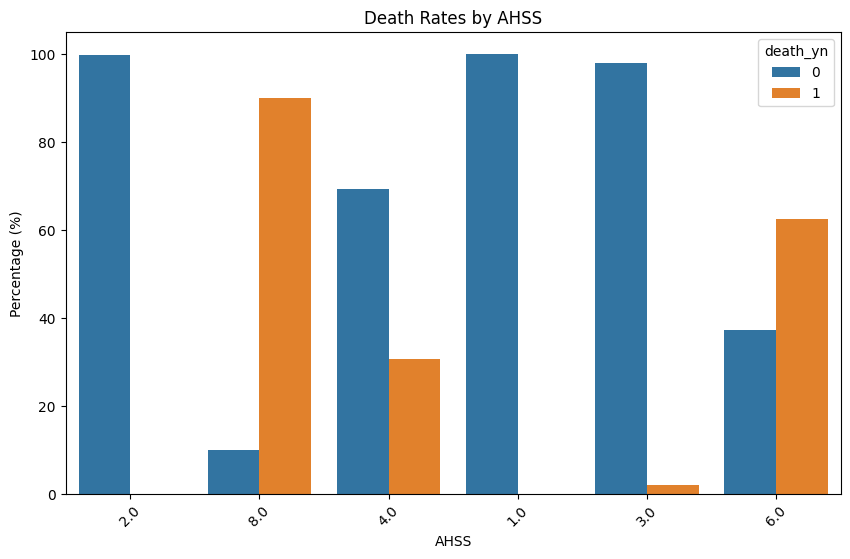

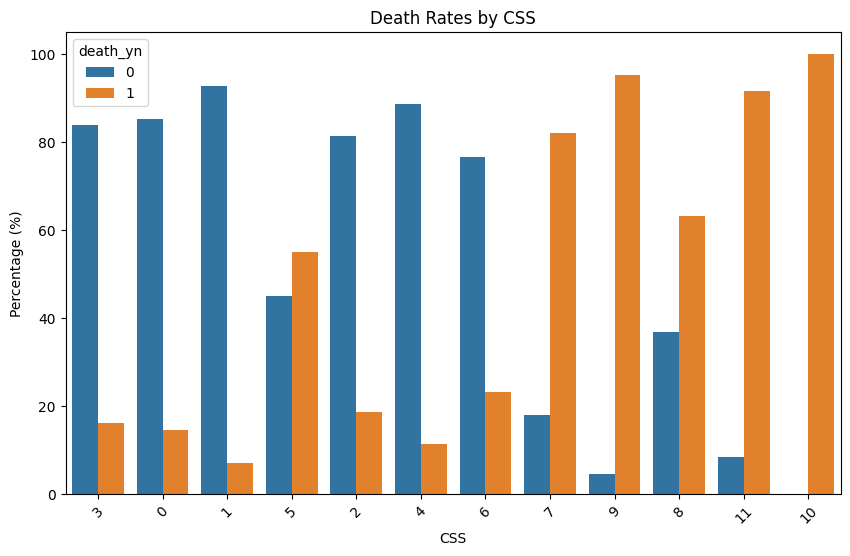

In [47]:
new_features = ['AHSS','CSS']
for col in new_features:
    # Filter for the top 20 most common categories in each column
    top_categories = train_df_extra_features[col].value_counts().nlargest(20).index

    # Create a DataFrame to hold percentages, limited to the top 20 categories
    percentage_df_extra_features = (train_df_extra_features[train_df_extra_features[col].isin(top_categories)]  # Filter to keep only the top categories
                     .groupby(col, observed=False)['death_yn']
                     .value_counts(normalize=True)  # Get percentage
                     .mul(100)  # Convert to percentage
                     .rename('percentage')  # Rename the series
                     .reset_index())  # Convert series to DataFrame

    # Plotting
    plt.figure(figsize=(10, 6))  # Set the figure size for each plot
    sns.barplot(x=col, y='percentage', hue='death_yn', data=percentage_df_extra_features,
                order=top_categories)  # Ensure the order of categories
    plt.title(f'Death Rates by {col}')
    plt.xlabel(col)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend(title='death_yn')
    plt.show()


### AHSS Interaction:
The distribution of death rates across different levels of AHSS suggests that as AHSS increases, the percentage of deaths tends to rise. This pattern indicates that AHSS is a promising feature for predicting mortality, likely capturing the risk factors associated with age and hospitalization severity that correlate with the likelihood of death.

### CSS Interaction:
Similarly, CSS displays a varying death rate, with certain scores correlating with higher mortality. The variability in death rates across CSS levels supports its potential as a strong predictive feature, reflecting the overall case severity's impact on patient outcomes.

These interactions underscore the value of AHSS and CSS as features in the model, providing nuanced insights that can enhance the predictive accuracy for death in COVID-19 cases.


In [48]:

promising_categorical_cols_nf = ['age_group', 'icu_yn', 'underlying_conditions_yn', 'hosp_yn', 'res_state', 'month','AHSS','CSS']


X_train_nf = train_df_extra_features[promising_categorical_cols_nf]
X_test_nf = test_df_extra_features[promising_categorical_cols_nf]
y_train_nf = train_df_extra_features['death_yn']
y_test_nf = test_df_extra_features['death_yn']

# One-hot encode the categorical features
X_train_encoded_nf = pd.get_dummies(X_train_nf)
X_test_encoded_nf = pd.get_dummies(X_test_nf)

In [49]:
nf_rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

nf_rf_classifier.fit(X_train_encoded_nf, y_train_nf)


RandomForestClassifier(random_state=42)

Text(0.5, 0, 'Random Forest Feature Importance')

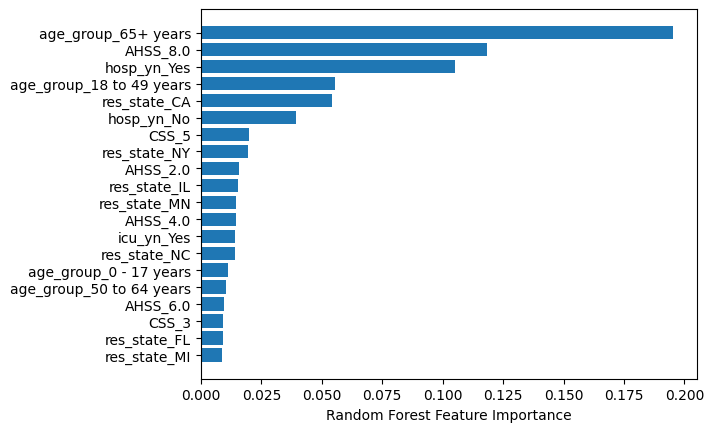

In [50]:
sorted_idx = nf_rf_classifier.feature_importances_.argsort()[-20:]
plt.barh(X_train_encoded_nf.columns[sorted_idx], nf_rf_classifier.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")


#### Feature Importance in Random Forest Model

The inclusion of Age Hospital Severity Score (AHSS) and Case Severity Score (CSS) has proven to be significant in the new Random Forest model for predicting COVID-19 mortality. Both features have emerged as important predictors, indicating their valuable contribution to the model's ability to discern the likelihood of death among patients.


In [51]:

y_pred_train = nf_rf_classifier.predict(X_train_encoded_nf)
cm_train = confusion_matrix(y_train_nf, y_pred_train)
print("Confusion Matrix\n",cm_train)

report_train = classification_report(y_train_nf, y_pred_train)
print(report_train)


Confusion Matrix
 [[27329   465]
 [  617  6200]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     27794
           1       0.93      0.91      0.92      6817

    accuracy                           0.97     34611
   macro avg       0.95      0.95      0.95     34611
weighted avg       0.97      0.97      0.97     34611



In [52]:

y_pred_test = nf_rf_classifier.predict(X_test_encoded_nf)
cm_test = confusion_matrix(y_test_nf, y_pred_test)
print("Confusion Matrix\n",cm_test)

report_test = classification_report(y_test_nf, y_pred_test)
print(report_test)

Confusion Matrix
 [[11448   381]
 [  396  2609]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     11829
           1       0.87      0.87      0.87      3005

    accuracy                           0.95     14834
   macro avg       0.92      0.92      0.92     14834
weighted avg       0.95      0.95      0.95     14834



In [53]:
y_nf = df_extra_features['death_yn']
X_encoded_nf = pd.get_dummies(df_extra_features[promising_categorical_cols_nf])

# Setup repeated random splits
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=7)
nf_new_rf_model = RandomForestClassifier(n_estimators=50, random_state=7)
precision_scores, recall_scores, f1_scores, accuracy_scores = [], [], [], []

for train_index, test_index in rskf.split(X_encoded_nf, y_nf):
    # Split the data
    X_train_new, X_test_new = X_encoded_nf.iloc[train_index], X_encoded_nf.iloc[test_index]
    y_train_new, y_test_new = y.iloc[train_index], y.iloc[test_index]
    nf_new_rf_model.fit(X_train_new, y_train_new)
    y_pred = nf_new_rf_model.predict(X_test_new)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_new, y_pred, average='binary')
    accuracy = accuracy_score(y_test_new, y_pred)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Display the average performance over all the splits
print(f"Average Precision: {np.mean(precision_scores)}")
print(f"Average Recall: {np.mean(recall_scores)}")
print(f"Average F1-Score: {np.mean(f1_scores)}")
print(f"Average Accuracy: {np.mean(accuracy_scores)}")

Average Precision: 0.876482448718116
Average Recall: 0.8661661043827056
Average F1-Score: 0.871276330067554
Average Accuracy: 0.9491657397107897


## Comparative Analysis of Random Forest Models for COVID-19 Death Prediction

This Random Forest model incorporates two new features – Age Hospital Severity Score (AHSS) and Case Severity Score (CSS). Below is an assessment of its performance relative to the previous models.

### Random Forest with New Features Performance
#### Training Data Metrics:
- **Precision for Death:** 0.93
- **Recall for Death:** 0.91
- **F1-Score for Death:** 0.92
- **Overall Accuracy:** 97%

#### Test Data Metrics:
- **Precision for Death:** 0.88
- **Recall for Death:** 0.87
- **F1-Score for Death:** 0.87
- **Overall Accuracy:** 95%

### Comparison with Other Models
The Random Forest with new features has outperformed the previous models in both precision and recall metrics, particularly in the training set. Its F1-score for death predictions is the highest we've seen, suggesting a better balance between precision and recall.

#### Ensemble Model Metrics Recap (Test Data):
- **Precision for Death:** 0.88
- **Recall for Death:** 0.86
- **F1-Score for Death:** 0.87
- **Overall Accuracy:** 95%

#### Original Random Forest Metrics Recap (Test Data):
- **Precision for Death:** 0.87
- **Recall for Death:** 0.84
- **F1-Score for Death:** 0.85
- **Overall Accuracy:** 94%

### Model Evaluation
- The **Random Forest with new features** shows an improvement in recall over the original Random Forest model, indicating its enhanced ability to correctly identify cases that result in death – a crucial factor in a healthcare setting.
- Compared to the Ensemble model, it shows a similar precision but a slightly higher recall on the test data, which could result in fewer missed opportunities for life-saving interventions.
- It is worth noting the higher precision and recall in the training data, suggesting that the new features contribute to a more accurate model.

### Choosing the Best Model
- While all models maintain high overall accuracy, the **Random Forest with New Features** emerges as the most promising, combining high accuracy with the highest precision and recall scores.
- It indicates that including more informative features like AHSS and CSS can significantly improve a model's predictive performance.
- Given the high stakes of COVID-19 mortality prediction, the ability to identify as many true positives as possible without raising too many false alarms (high recall and precision) is the primary consideration, making this model the best among the ones compared.

In conclusion, the inclusion of the AHSS and CSS features has given the best predictive performance for COVID-19 mortality. This finding underlines the importance of feature engineering in enhancing model efficacy, especially in complex, high-consequence domains such as healthcare.
